## Preparation
Make the file structure:

In [1]:
import os, shutil

base_dir = 'data_small'

def rm_dir(my_dir):
    if os.path.exists(my_dir):
        shutil.rmtree(my_dir)

rm_dir(base_dir)

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

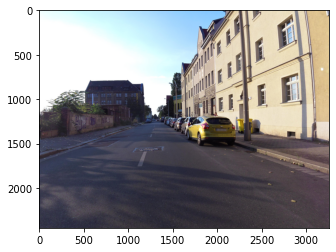

img.shape: (2448, 3264, 3)


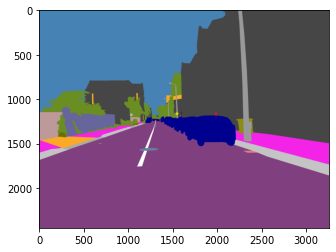

label.shape: (2448, 3264, 3)


In [3]:
from keras import utils
import matplotlib.pyplot as plt

file_name = os.listdir(train_x_dir)[0]
img = utils.load_img(os.path.join(train_x_dir, file_name))
img = utils.img_to_array(img)
img /= 255

plt.imshow(img)
plt.show()
print('img.shape: ' + str(img.shape))

file_name = os.listdir(train_y_dir)[0]
label = utils.load_img(os.path.join(train_y_dir, file_name))
label = utils.img_to_array(label)
label /= 255
plt.imshow(label)
plt.show()
print('label.shape: ' + str(label.shape))

Enumerating the categories produces arbitrary values, while one-hot encoding (one matrix per category) is high-dimensional and sparse. For this reason we'll train an autoencoder to learn its own encodings:

In [23]:
from keras import models
from keras import layers
from keras import optimizers

input_width = 256
input_height = 256
input_shape = (input_width, input_height, 3)

encoder = models.Sequential()
encoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='selu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()

decoder.add(layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding='same', activation='selu', input_shape=(64, 64, 16)))
decoder.add(layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='softmax'))
decoder.add(layers.Reshape(input_shape))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 64, 64, 16)        1392      
                                                                 
 sequential_25 (Sequential)  (None, 256, 256, 3)       1379      
                                                                 
Total params: 2,771
Trainable params: 2,771
Non-trainable params: 0
_________________________________________________________________


Let's start training:

In [24]:
batch_size = 20
num_epochs = 32
normalizer = layers.Rescaling(1./255)

def get_gen(x_dir, y_dir):
    x_dataset = utils.image_dataset_from_directory(
        x_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    )
    
    x_dataset = x_dataset.map(lambda x: normalizer(x))
    x_dataset = x_dataset.repeat()
    
    y_dataset = utils.image_dataset_from_directory(
        y_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    ).repeat()
    
    y_dataset = y_dataset.map(lambda x: normalizer(x))
    y_dataset = y_dataset.repeat()
    
    return zip(x_dataset, y_dataset)

train_gen = get_gen(train_x_dir, train_y_dir)
val_gen = get_gen(val_x_dir, val_y_dir)

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_size//batch_size
)

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Epoch 1/32
40/40 [==============================] - 22s 439ms/step - loss: 0.7014 - val_loss: 0.6939
Epoch 2/32
40/40 [==============================] - 22s 563ms/step - loss: 0.6928 - val_loss: 0.6901
Epoch 3/32
40/40 [==============================] - 21s 528ms/step - loss: 0.6905 - val_loss: 0.6884
Epoch 4/32
40/40 [==============================] - 18s 450ms/step - loss: 0.6890 - val_loss: 0.6868
Epoch 5/32
40/40 [==============================] - 19s 490ms/step - loss: 0.6874 - val_loss: 0.6856
Epoch 6/32
40/40 [==============================] - 24s 601ms/step - loss: 0.6860 - val_loss: 0.6848
Epoch 7/32
40/40 [==============================] - 22s 548ms/step - loss: 0.6851 - val_loss: 0.6838
Epoch 8/32
40/40 [==============================] - 23s 580ms/step - loss: 0.6844 - val_loss: 0.6833
Epoch 9/32
40/40 [==============

Found 100 files belonging to 1 classes.
4/4 [==============================] - 1s 214ms/step


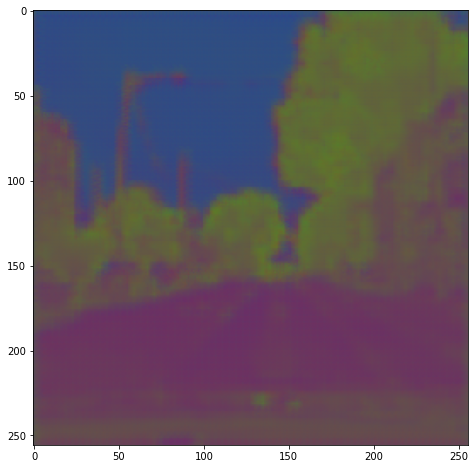

In [32]:
import matplotlib.pyplot as plt

test_gen = utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    image_size=(input_height, input_width),
    shuffle=False
)

test_gen = test_gen.map(lambda x: normalizer(x))

predictions = autoencoder.predict(test_gen)
plt.figure(figsize=(8, 8))
plt.imshow(predictions[0])
plt.show()